In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import joblib
from tensorflow.keras.regularizers import l2


%matplotlib inline

In [21]:
X = pd.read_csv("data-preNOx-train.csv")
y = X["target"]
X.drop(["target"], axis=1, inplace=True)

In [22]:
poly = PolynomialFeatures(degree=2)
poly_X = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(poly_X, y, test_size=0.2, random_state=42, shuffle=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5428, 91), (1357, 91), (5428,), (1357,))

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mean_absolute_error'])
history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_data=(X_test, y_test), callbacks=early_stopping)

Epoch 1/500
43/43 [==============================] - 1s 3ms/step - loss: 93901.5625 - mean_absolute_error: 221.6382 - val_loss: 34396.4727 - val_mean_absolute_error: 126.4920
Epoch 2/500
43/43 [==============================] - 0s 2ms/step - loss: 29527.1836 - mean_absolute_error: 134.0230 - val_loss: 20182.2676 - val_mean_absolute_error: 110.1489
Epoch 3/500
43/43 [==============================] - 0s 2ms/step - loss: 16448.1465 - mean_absolute_error: 96.1344 - val_loss: 11131.9922 - val_mean_absolute_error: 72.0568
Epoch 4/500
43/43 [==============================] - 0s 2ms/step - loss: 9199.7158 - mean_absolute_error: 63.0092 - val_loss: 8216.8428 - val_mean_absolute_error: 58.2793
Epoch 5/500
43/43 [==============================] - 0s 2ms/step - loss: 7644.4585 - mean_absolute_error: 56.7451 - val_loss: 7571.7090 - val_mean_absolute_error: 56.3247
Epoch 6/500
43/43 [==============================] - 0s 2ms/step - loss: 7115.7334 - mean_absolute_error: 55.0033 - val_loss: 7312.7739

In [25]:
history.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

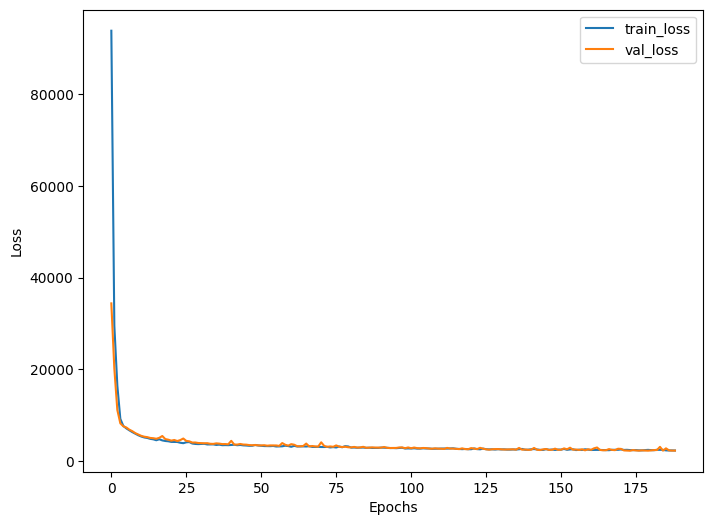

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


43/43 [==============================] - 0s 372us/step


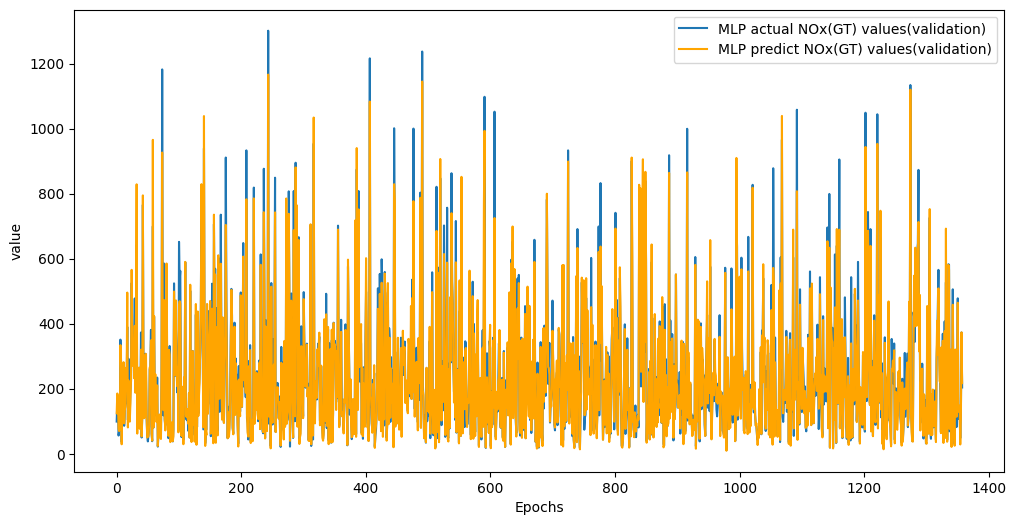

In [27]:
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, len(y_test), len(y_test)), y_test.values, label="MLP actual NOx(GT) values(validation)")
plt.plot(np.linspace(0, len(y_test), len(y_test)), model.predict(X_test), color="orange", label="MLP predict NOx(GT) values(validation)")
plt.xlabel('Epochs')
plt.ylabel('value')
plt.legend()
plt.show()

In [28]:
RMSE = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
MAE = mean_absolute_error(y_test, model.predict(X_test))
RMSE, MAE, len(y_test)

43/43 [==============================] - 0s 498us/step


(47.31819062863799, 29.010747201001724, 1357)

In [29]:
model.save("regression_model.h5")
# model_para_yaml = model.to_yaml()
# with open("model_para.yaml", 'w') as f:
#     f.write(model_para_yaml)
# model.save_weights("model_weights.h5")


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### 经过对比发现，通过多项式变换创造了新的特征后，可以让模型更好的学习到数据之间的关系，有效的降低损失值

In [30]:
# from tensorflow.keras.models import load_model

# model_load = load_model("regression_model.h5")
# model_load.summary()

In [31]:
# from sklearn.model_selection import GridSearchCV
# from scikeras.wrappers import KerasRegressor


# def create_model(optimizer='adam', activation='relu'):
#     model = Sequential()
#     model.add(Dense(128, input_shape=(poly_X.shape[1],), activation=activation))
#     model.add(Dense(64, activation=activation))
#     model.add(Dense(32, activation=activation))
#     model.add(Dense(1))
#     model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])
#     return model

# model = KerasRegressor(build_fn=create_model, optimizer='adam', activation='relu', epochs=50, batch_size=32, verbose=0)

# para_dict = {
#     # "optimizer" : ['adam', 'rmsprop'],
#     "activation" : ["relu", "tanh"],
#     "epochs" : [150]
# }

# grid = GridSearchCV(estimator=model, param_grid=para_dict, n_jobs=-1, cv=5)


In [32]:
# gird_res = grid.fit(poly_X, y)
# gird_res.best_params_

In [33]:
# joblib.dump(gird_res.best_estimator_, "best_model.pkl")
# with open("build_fn.pkl", "wb") as f:
#     joblib.dump(create_model, f)

In [34]:
# build_fn = joblib.load("build_fn.pkl")
# best_model = joblib.load('best_model.pkl')

In [35]:
# best_model.model = build_fn

In [36]:
# mean_absolute_error(best_model.predict(X_test), y_test)

#### 线性方程回归

In [39]:
from sklearn.linear_model import LinearRegression

clf = LinearRegression()
clf.fit(X_train, y_train)
test_pred = clf.predict(X_test)
score = mean_absolute_error(test_pred, y_test)
print(score)

39.34268341638689


#### K近邻

In [42]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV


clf = KNeighborsRegressor(n_neighbors=3)
clf.fit(X_train, y_train)
test_pred = clf.predict(X_test)
score = mean_absolute_error(test_pred, y_test)
score


33.67880127732744

In [43]:
param_grid = {'n_neighbors': np.arange(1, 20)}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
print("最佳 k 值:", grid_search.best_params_)
print("最佳 k 值对应的平均绝对误差:", -grid_search.best_score_)

最佳 k 值: {'n_neighbors': 5}
最佳 k 值对应的平均绝对误差: 36.38223063200685


In [44]:
best_knn = grid_search.best_estimator_
test_pred = best_knn.predict(X_test)
score = mean_absolute_error(test_pred, y_test)
print("测试集上的平均绝对误差:", score)

测试集上的平均绝对误差: 33.989815770081066


#### 决策树

In [45]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()
clf.fit(X_train, y_train)
test_pred = clf.predict(X_test)
score = mean_absolute_error(test_pred, y_test)
score

47.15195283714075

In [46]:
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
}
grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring="neg_mean_absolute_error")
grid_search.fit(X_train, y_train)
print("最佳参数:", grid_search.best_params_)
print("最佳参数对应的平均绝对误差:", -grid_search.best_score_)
best_clf = grid_search.best_estimator_
test_pred = best_clf.predict(X_test)
score = mean_absolute_error(test_pred, y_test)
print("测试集上的平均绝对误差:", score)

最佳参数: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10}
最佳参数对应的平均绝对误差: 42.49880985346139
测试集上的平均绝对误差: 41.79166876188173


#### 随机森林

In [49]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=200, n_jobs=-1)
clf.fit(X_train, y_train)
test_pred = clf.predict(X_test)
score = mean_absolute_error(test_pred, y_test)
print(score)

32.58179982980665


In [50]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'max_features': ['sqrt', 'log2', 0.5]
}

random_search = RandomizedSearchCV(clf, param_distributions, n_iter=50, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
print("最佳参数:", grid_search.best_params_)
print("最佳参数对应的平均绝对误差:", -grid_search.best_score_)
best_clf = random_search.best_estimator_
test_pred = best_clf.predict(X_test)
score = mean_absolute_error(test_pred, y_test)
print("测试集上的平均绝对误差:", score)

C:\Users\learn\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 36 is smaller than n_iter=50. Running 36 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


最佳参数: {'max_depth': None, 'min_samples_leaf': 10, 'min_samples_split': 10}
最佳参数对应的平均绝对误差: 42.49880985346139
测试集上的平均绝对误差: 32.01057371153779


In [52]:
from lightgbm import LGBMRegressor


regressor = LGBMRegressor()
regressor.fit(X_train, y_train)
test_pred = regressor.predict(X_test)
score = mean_absolute_error(test_pred, y_test)
score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21986
[LightGBM] [Info] Number of data points in the train set: 5428, number of used features: 90
[LightGBM] [Info] Start training from score 247.922089


32.84877258901298

In [53]:
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.01],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(regressor, param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("最佳参数:", grid_search.best_params_)
best_regressor = grid_search.best_estimator_
predictions = best_regressor.predict(X_test)
mse = mean_absolute_error(y_test, predictions)
print("平均绝对值误差:", mse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 21986
[LightGBM] [Info] Number of data points in the train set: 5428, number of used features: 90
[LightGBM] [Info] Start training from score 247.922089
最佳参数: {'learning_rate': 0.1, 'n_estimators': 200, 'num_leaves': 50}
均方误差: 31.593038073036332


#### SVR

In [54]:
from sklearn.svm import SVC, SVR

regressor = SVR(kernel='linear', C=1.0)
regressor.fit(X_train, y_train)
predictions = regressor.predict(X_test)
socre = mean_absolute_error(predictions, y_test)
score

32.84877258901298

In [56]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}
grid_search = GridSearchCV(regressor, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("最佳参数:", grid_search.best_params_)
print("最佳参数对应的准确率:", grid_search.best_score_)
best_classifier = grid_search.best_estimator_
predictions = best_classifier.predict(X_test)
score = mean_absolute_error(y_test, predictions)
print("测试集上的准确率:", score)


最佳参数: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}
最佳参数对应的准确率: -41.97558560187328
测试集上的准确率: 41.94951071867837
